<a href="https://colab.research.google.com/github/zooodung/Face_Image_Emotion_Classification/blob/JS/FP_PREPROCESSING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocess

## Data Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import json
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from skimage import color
import dlib

In [ ]:
TRAIN_JSON_PATH = '/content/drive/MyDrive/Project/Data/label/train/'
VALID_JSON_PATH = '/content/drive/MyDrive/Project/Data/label/val/'

TRAIN_IMG_PATH = '/content/drive/MyDrive/Project/Data/img/train/'
VALID_IMG_PATH = '/content/drive/MyDrive/Project/Data/img/val/'

TRAIN_SEGMENT_PATH = '/content/drive/MyDrive/Project/Data/segmentation/train/'
VALID_SEGMENT_PATH = '/content/drive/MyDrive/Project/Data/segmentation/val/'

AFTER_PREPROCESSING_IMG_PATH = '/content/drive/MyDrive/Project/Data/img_preprocessing/train/'

In [ ]:
with open (TRAIN_JSON_PATH + "train_anger.json", "r", encoding='euc-kr') as f:
    anger_label = json.load(f)
with open (TRAIN_JSON_PATH + "train_happy.json", "r", encoding='euc-kr') as f:
    happy_label = json.load(f)
with open (TRAIN_JSON_PATH + "train_panic.json", "r", encoding='euc-kr') as f:
    panic_label = json.load(f)
with open (TRAIN_JSON_PATH + "train_sadness.json", "r", encoding='euc-kr') as f:
    sadness_label = json.load(f)

anger_segment = np.load(TRAIN_SEGMENT_PATH + 'train_anger.npz')
happy_segment = np.load(TRAIN_SEGMENT_PATH + 'train_happy.npz')
panic_segment = np.load(TRAIN_SEGMENT_PATH + 'train_panic.npz')
sadness_segment = np.load(TRAIN_SEGMENT_PATH + 'train_sadness.npz')

## Label 데이터

### annotation 검증

In [ ]:
def print_faceExp_count(counts, emotion):
    print(f"Counts for emotion '{emotion}'")
    print(f"  Zero annotation same   : {counts['zero']}")
    print(f"  One annotation same    : {counts['one']}")
    print(f"  Two annotations same   : {counts['two']}")
    print(f"  Three annotations same : {counts['three']}")
    print(f"  Sum of two, three : {counts['two'] + counts['three']}")
    print(f"  Sum of all        : {counts['zero'] + counts['one'] + counts['two'] + counts['three']}")

def verify_faceExp_consistent(label, emotion):
  counts = {'zero': 0, 'one': 0, 'two': 0, 'three': 0}
  verified_data = []

  for i in range(len(label)):
    emotion_count = 0
    for annot in ['annot_A', 'annot_B', 'annot_C']:
      if label[i][annot]['faceExp'] == emotion:
        emotion_count += 1

    if emotion_count == 1:
      counts['one'] += 1
    elif emotion_count == 2: # 2개 이상 일치시 리스트 추가
      counts['two'] += 1
      verified_data.append(label[i])
    elif emotion_count == 3: # 3개 일치시 리스트 추가
      counts['three'] += 1
      verified_data.append(label[i])
    else :
      counts['zero'] += 1

  print_faceExp_count(counts, emotion)

  return verified_data

In [ ]:
verified_anger = verify_faceExp_consistent(anger_label, '분노')
verified_happy = verify_faceExp_consistent(happy_label, '기쁨')
verified_panic = verify_faceExp_consistent(panic_label, '당황')
verified_sadness = verify_faceExp_consistent(sadness_label, '슬픔')

Counts for emotion '분노'
  Zero annotation same   : 151
  One annotation same    : 231
  Two annotations same   : 398
  Three annotations same : 720
  Sum of two, three : 1118
  Sum of all        : 1500
Counts for emotion '기쁨'
  Zero annotation same   : 7
  One annotation same    : 13
  Two annotations same   : 76
  Three annotations same : 1398
  Sum of two, three : 1474
  Sum of all        : 1494
Counts for emotion '당황'
  Zero annotation same   : 170
  One annotation same    : 228
  Two annotations same   : 386
  Three annotations same : 716
  Sum of two, three : 1102
  Sum of all        : 1500
Counts for emotion '슬픔'
  Zero annotation same   : 146
  One annotation same    : 234
  Two annotations same   : 414
  Three annotations same : 706
  Sum of two, three : 1120
  Sum of all        : 1500


In [ ]:
print(len(verified_anger))
print(len(verified_happy))
print(len(verified_panic))
print(len(verified_sadness))

1118
1474
1102
1120


In [ ]:
anger = verified_anger[:1102]
happy = verified_happy[:1102]
panic = verified_panic
sadness = verified_sadness[:1102]

print(len(anger))
print(len(happy))
print(len(panic))
print(len(sadness))

1102
1102
1102
1102


## IMG 데이터

### 라이브러리

In [ ]:
! pip install mtcnn
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
from mtcnn import MTCNN

### 함수 정의

##### Face만 출력하는 함수

In [ ]:
def mask_img(filename, path, segment):
  image = cv2.imread(TRAIN_IMG_PATH + path + filename)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  new_img = image.copy()

  # 이미지 face 만 남기고 나머지는 가림
  new_img[segment[filename] == 0] = 0
  new_img[segment[filename] == 1] = 0
  new_img[segment[filename] == 2] = 0
  new_img[segment[filename] == 4] = 0
  new_img[segment[filename] == 5] = 0

  return new_img

##### Label 데이터를 기반으로 이미지 Crop하는 함수

In [ ]:
def crop_face(label_data, img):

  boxes = [label_data['annot_A']['boxes'], label_data['annot_B']['boxes'], label_data['annot_C']['boxes']]
  avg_box = { # annot_A/B/C 각 좌표의 평균 값 구해서 저장
      'maxX': np.mean([box['maxX'] for box in boxes]),
      'maxY': np.mean([box['maxY'] for box in boxes]),
      'minX': np.mean([box['minX'] for box in boxes]),
      'minY': np.mean([box['minY'] for box in boxes])
  }

  new_image = img[int(avg_box['minY']):int(avg_box['maxY']), int(avg_box['minX']):int(avg_box['maxX'])] # 평균값으로 이미지 crop

  return new_image

##### 바운딩 박스와 특징점을 추출하는 함수

In [ ]:
def extract_face_info_mtcnn(label_data, img):
  detector = MTCNN() # MTCNN 인스턴스 생성

  faces = detector.detect_faces(img) # 얼굴 감지
  #face_info_list = [] # 감지된 얼굴 정보를 저장할 리스트 // 하나의 이미지에 다수의 얼굴이 존재할 경우 사용

  # 감지된 모든 얼굴에 대해 반복
  for face in faces:
    # 얼굴의 바운딩 박스와 특징점 추출
    bounding_box = face['box']
    keypoints = face['keypoints']

    # 추출한 정보를 딕셔너리로 저장
    face_info = {
      'filename': label_data['filename'],
      'bounding_box': bounding_box,
      'keypoints': keypoints
    }

    # 얼굴 정보 리스트에 추가
    #face_info_list.append(face_info)

  return face_info

##### 추출한 바운딩 박스와 특징점을 이미지로 출력하는 함수

In [ ]:
#def print_face_info(image, face_info_list):
def print_face_info_mtcnn(image, face_info):
  # 이미지 복사
  image_with_info = image.copy()

  #for face_info in face_info_list:
  # 바운딩 박스 좌표
  x, y, w, h = face_info['bounding_box']

  # 바운딩 박스 그리기
  cv2.rectangle(image_with_info, (x, y), (x+w, y+h), (0, 255, 0), 2)
  # 특징점 그리기
  for key, point in face_info['keypoints'].items():
    cv2.circle(image_with_info, point, 5, (0, 0, 255), -1)

  # 이미지를 RGB로 변환하여 matplotlib로 표시
  image_with_info_rgb = cv2.cvtColor(image_with_info, cv2.COLOR_BGR2RGB) # RGB 변환
  plt.imshow(image_with_info_rgb)
  plt.axis('off')
  plt.show()


##### 'left_eye'와 'right_eye'를 수평으로 이미지를 회전하는 함수

In [ ]:
def rotate_image(image, angle):
  # 이미지의 중심 탐색
  height, width = image.shape[:2]
  center = (width / 2, height / 2)

  # 회전 변환 매트릭스 생성
  rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

  # 이미지 회전
  rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))

  return rotated_image

##### 이미지 회전과 같이 키포인트를 회전하는 함수

In [ ]:
def rotate_keypoints(keypoints, angle, center):
  # 기울기(angle)에 따라 키포인트를 회전
  angle_rad = np.radians(angle)
  rotated_keypoints = {}
  for key, point in keypoints.items():
      rotated_x = int((point[0] - center[0]) * np.cos(angle_rad) - (point[1] - center[1]) * np.sin(angle_rad) + center[0])
      rotated_y = int((point[0] - center[0]) * np.sin(angle_rad) + (point[1] - center[1]) * np.cos(angle_rad) + center[1])
      rotated_keypoints[key] = (rotated_x, rotated_y)

  return rotated_keypoints

##### 기울기를 계산하는 함수

In [ ]:
def calculate_angle(face_info):
  left_eye = face_info['keypoints']['left_eye']
  right_eye = face_info['keypoints']['right_eye']

  return np.arctan2(right_eye[1] - left_eye[1], right_eye[0] - left_eye[0]) * 180 / np.pi

#### Zero-Centering

In [ ]:
def zero_centering(img):
  img_new = img.astype(np.float32)
  mean = np.mean(img)
  zero_centered_image = img - mean

  return zero_centered_image

#### Z-score Scaling

In [ ]:
def zscore_scaling(image):
  # 2차원으로 reshape // 이미지 평탄화
  original_shape = image.shape
  flat_image = image.reshape(-1, original_shape[-1])

  # 스케일러 적용
  scaler = StandardScaler()
  scaled_flat_image = scaler.fit_transform(flat_image)

  # 3차원으로 reshape
  scaled_image = scaled_flat_image.reshape(original_shape)

  return scaled_image

#### 랜드마크 비율 정규화 (눈 사이 거리 정규화/코 끝을 중심으로 이동/output_size 224x224)

In [ ]:
def normalize_face(image, landmarks, output_size=(224, 224)):
    left_eye = np.array(landmarks['left_eye'])
    right_eye = np.array(landmarks['right_eye'])
    nose_tip = np.array(landmarks['nose'])

    # 눈 사이 거리
    eye_distance = np.linalg.norm(left_eye - right_eye)

    # 스케일링 비율
    desired_eye_distance = 0.3 * output_size[0]
    scale = desired_eye_distance / eye_distance

    # 눈 사이 거리 정규화
    M = np.array([[scale, 0, 0], [0, scale, 0]])
    scaled_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    # 코 끝을 기준으로 중심 이동
    eyes_center = ((left_eye + right_eye) * scale) / 2
    nose_center = nose_tip * scale
    offset_x = output_size[0] / 2 - nose_center[0]
    offset_y = output_size[1] / 2 - nose_center[1]
    M = np.array([[1, 0, offset_x], [0, 1, offset_y]])
    normalized_image = cv2.warpAffine(scaled_image, M, output_size)

    return normalized_image

#### CLAHE 생성

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

#### Dlib 이미지 특징점 추출

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/Project/Data/shape_predictor_68_face_landmarks.dat')

def extract_face_info_dlib(img):
  faces = detector(img, 1)

  #if len(faces) == 0:
  #  print("얼굴을 찾을 수 없습니다.")
  #  return

  for face in faces:
    # 얼굴 영역 추출
    x1 = face.left()
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()
    face_area = img[y1:y2, x1:x2]

    # 얼굴 특징점 추출
    landmarks = predictor(img, face)

  return landmarks

def print_face_info_dlib(img):
  faces = detector(img, 1)

  #if len(faces) == 0:
  #  print("얼굴을 찾을 수 없습니다.")
  #  return

  for face in faces:
    # 얼굴 영역 추출
    x1 = face.left()
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()
    face_area = img[y1:y2, x1:x2]

    # 얼굴 특징점 추출
    landmarks = predictor(img, face)

    # 68개의 특징점 출력
    for point in landmarks.parts():
      x = point.x
      y = point.y
      cv2.circle(img, (x, y), 2, (0, 255, 0), -1)

  # 결과 이미지 출력
  plt.imshow(img)


In [ ]:
# 얼굴 검출기 및 특징점 추출기 로드
#detector = dlib.get_frontal_face_detector()
#predictor = dlib.shape_predictor('/content/drive/MyDrive/Project/Data/shape_predictor_68_face_landmarks.dat')

# 이미지에서 얼굴 검출
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#faces = detector(gray)

# 각 얼굴마다 특징점 추출
#for face in faces:
#  landmarks = predictor(gray, face)

  # 특징점 좌표를 기반으로 이미지에 점 표시
#  for i in range(68):
#    x = landmarks.part(i).x
#    y = landmarks.part(i).y
#    cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

  # 특징점 연결
  #for i in range(16):
  #  cv2.line(image, (landmarks.part(i).x, landmarks.part(i).y), (landmarks.part(i+1).x, landmarks.part(i+1).y), (0, 255, 0), 2)

# 결과 이미지 출력
#plt.imshow(image)

### 함수 호출 TEST

In [ ]:
from skimage import color

In [ ]:
img_masked = mask_img(anger[2]['filename'], 'anger/', anger_segment) # 이미지 face만 출력
img_cropped = crop_face(anger[2],img_masked) # 이미지 Crop
img_info_1 = extract_face_info_mtcnn(anger[2], img_cropped) # 이미지 특징점 추출
rotated_image = rotate_image(img_cropped, calculate_angle(img_info_1)) # 좌/우 눈을 수평으로 이미지 회전

#img_info['keypoints'] = rotate_keypoints(img_info['keypoints'], calculate_angle(img_info), (img_cropped.shape[1] // 2, img_cropped.shape[0] // 2)) # 키포인트 회전, 기존 키포인트 수정
img_normalized = normalize_face(rotated_image, img_info_1['keypoints']) # 눈사이 거리 정규화, 코 끝을 기준으로 가운데 이동
img_info = extract_face_info_dlib(img_normalized) # 이미지 특징점 재추출 Dlib
#img_info = extract_face_info(anger[2], img_normalized) # 이미지 특징점 재추출 mtcnn

img_grayscaled = cv2.cvtColor(img_normalized, cv2.COLOR_BGR2GRAY) # Grayscalling
img_clahe = clahe.apply(img_grayscaled) # CLAHE
#img_denoised = cv2.GaussianBlur(img_clahe, (5, 5), 0) # Denoising // Blur, Morphology 모두 고려해서 선택 진행
img_zerocenterd = zero_centering(img_clahe) # Zero-centering //Z-score 스케일링에는 불필요
img_scaled = zscore_scaling(img_zerocenterd) # 스케일링 // Min-Max, Z-score, L1 normalization, L2 normalization 모두 고려해서 선택 진행

#img_resized = cv2.resize(rotated_image, (224, 224)) # resizing
# Binarization
# Augmentation // 성능 향상, 1102개로 부족하다고 판단되면 추가

1/1 [==============================] - 0s 128ms/step


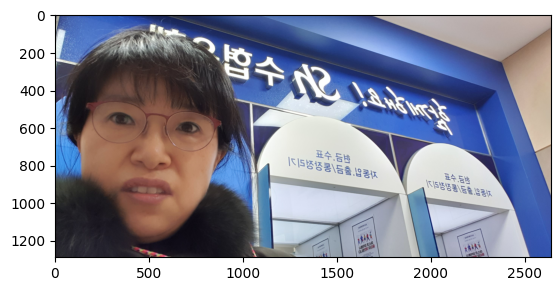

In [ ]:
image = cv2.imread(TRAIN_IMG_PATH + 'anger/' + anger[2]['filename'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

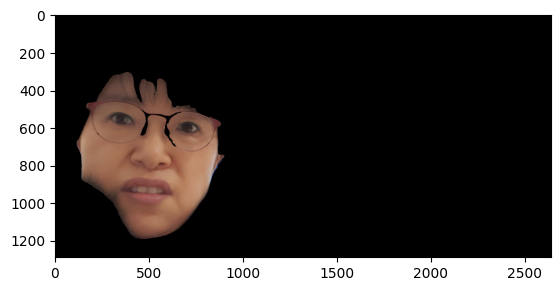

In [ ]:
plt.imshow(img_masked)

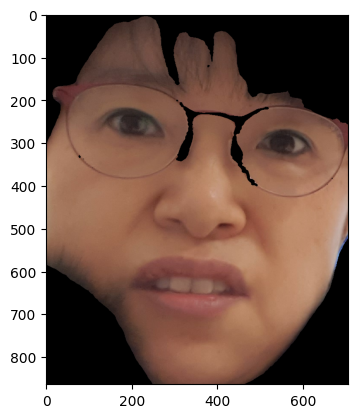

In [ ]:
plt.imshow(img_cropped)

In [ ]:
img_info_1

{'filename': 'llfycc0aa29599cc63cace3610fdaaad3a99aab2ee38c9edb6c10966765bbwd5f.jpg',
 'bounding_box': [24, 0, 696, 837],
 'keypoints': {'left_eye': (232, 271),
  'right_eye': (539, 311),
  'nose': (360, 469),
  'mouth_left': (221, 626),
  'mouth_right': (461, 652)}}

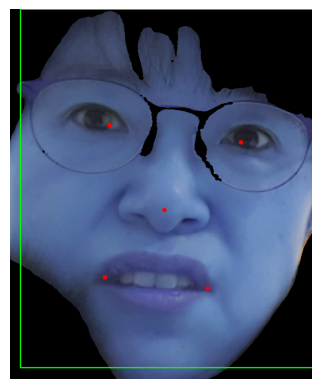

In [ ]:
print_face_info_mtcnn(img_cropped, img_info_1)

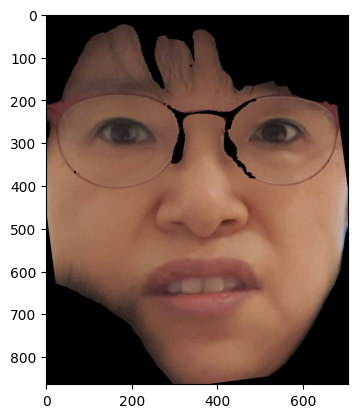

In [ ]:
plt.imshow(rotated_image)

In [ ]:
img_info_1

{'filename': 'llfycc0aa29599cc63cace3610fdaaad3a99aab2ee38c9edb6c10966765bbwd5f.jpg',
 'bounding_box': [24, 0, 696, 837],
 'keypoints': {'left_eye': (232, 271),
  'right_eye': (539, 311),
  'nose': (360, 469),
  'mouth_left': (221, 626),
  'mouth_right': (461, 652)}}

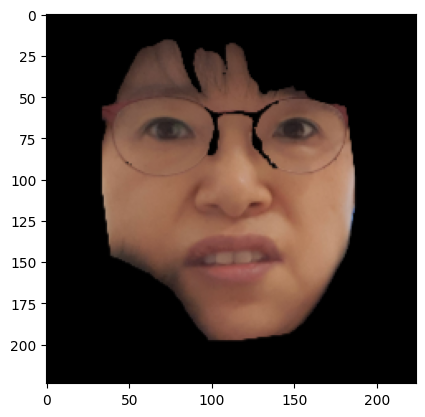

In [ ]:
plt.imshow(img_normalized)

In [ ]:
imginfo = extract_face_info_dlib(img_normalized)
for point in imginfo.parts():
  x = point.x
  y = point.y
  print(f"x: {x}, y: {y}")

x: 33, y: 79
x: 33, y: 98
x: 35, y: 119
x: 41, y: 137
x: 53, y: 153
x: 68, y: 167
x: 82, y: 182
x: 98, y: 196
x: 116, y: 199
x: 134, y: 196
x: 150, y: 185
x: 163, y: 172
x: 175, y: 156
x: 182, y: 137
x: 185, y: 117
x: 186, y: 96
x: 185, y: 76
x: 47, y: 56
x: 57, y: 47
x: 71, y: 42
x: 87, y: 43
x: 100, y: 49
x: 120, y: 50
x: 132, y: 42
x: 147, y: 41
x: 161, y: 46
x: 171, y: 55
x: 111, y: 69
x: 112, y: 82
x: 112, y: 95
x: 113, y: 108
x: 95, y: 120
x: 104, y: 123
x: 114, y: 125
x: 122, y: 122
x: 130, y: 119
x: 61, y: 72
x: 69, y: 67
x: 80, y: 67
x: 89, y: 74
x: 79, y: 76
x: 69, y: 76
x: 131, y: 74
x: 141, y: 67
x: 151, y: 67
x: 160, y: 72
x: 151, y: 76
x: 141, y: 76
x: 84, y: 150
x: 94, y: 140
x: 105, y: 135
x: 113, y: 136
x: 121, y: 134
x: 132, y: 138
x: 142, y: 148
x: 133, y: 157
x: 123, y: 162
x: 114, y: 164
x: 106, y: 163
x: 95, y: 159
x: 88, y: 150
x: 105, y: 145
x: 113, y: 145
x: 122, y: 144
x: 137, y: 148
x: 122, y: 151
x: 114, y: 152
x: 106, y: 152


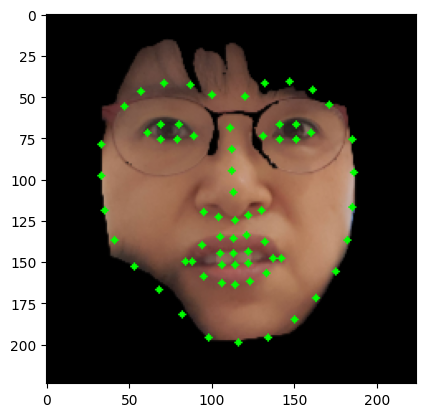

In [ ]:
print_face_info_dlib(img_normalized)

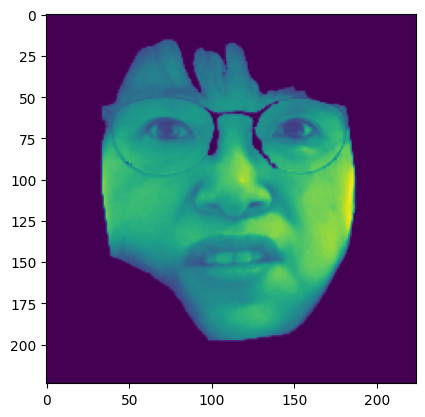

In [ ]:
plt.imshow(img_grayscaled)

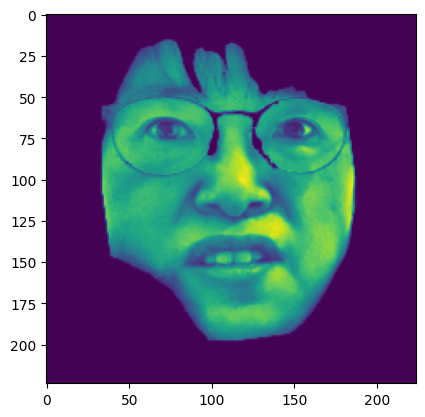

In [ ]:
plt.imshow(img_clahe)

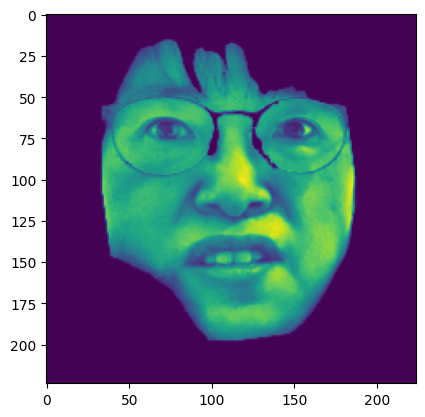

In [ ]:
plt.imshow(img_zerocenterd)

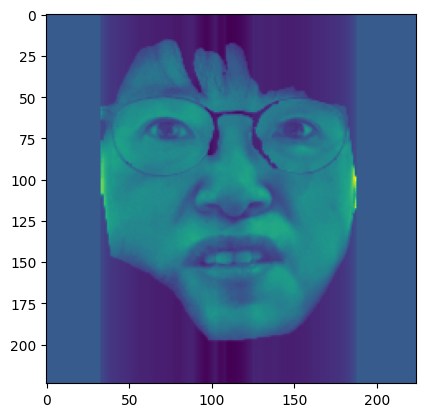

In [ ]:
plt.imshow(img_scaled)

### Train Data Preprocessing Pipeline

In [ ]:
class ProcessedImageData:
    def __init__(self, img_info, img):
        self.img_info = img_info
        self.img = img

In [ ]:
def train_data_preprocessing_pipeline(path, segment_data, label_data, length):
  processed_data = []

  for i in range(length):
    img_masked = mask_img(label_data[i]['filename'], path, segment_data) # 이미지 face만 출력
    img_cropped = crop_face(label_data[i],img_masked) # 이미지 Crop

    img_info = extract_face_info_mtcnn(label_data[i], img_cropped) # 이미지 특징점 추출
    img_rotated = rotate_image(img_cropped, calculate_angle(img_info)) # 좌/우 눈을 수평으로 이미지 회전
    #img_info['keypoints'] = rotate_keypoints(img_info['keypoints'], calculate_angle(img_info), (img_cropped.shape[1] // 2, img_cropped.shape[0] // 2)) # 키포인트 회전, 기존 키포인트 수정
    img_normalized = normalize_face(img_rotated, img_info['keypoints'])
    img_info = extract_face_info_dlib(img_normalized)
    #img_info = extract_face_info(label_data[i], img_normalized) # 이미지 특징점 재추출

    #img_grayscaled = cv2.cvtColor(img_normalized, cv2.COLOR_BGR2GRAY) # Grayscalling
    #img_clahe = clahe.apply(img_grayscaled) # CLAHE

    #img_denoised = cv2.GaussianBlur(img_clahe, (5, 5), 0) # Denoising

    #img_zerocenterd = zero_centering(img_clahe) # Zero-centering
    #img_scaled = zscore_scaling(img_zerocenterd) # Scaling

    #cv2.imwrite(AFTER_PREPROCESSING_IMG_PATH + path + label_data[i]['filename'],img_normalized) # 전처리된 이미지를 Export

    processed_data.append(ProcessedImageData(img_info, img_normalized))

  return processed_data

In [ ]:
anger_p = train_data_preprocessing_pipeline('anger/', anger_segment, anger, 5)
happy_p = train_data_preprocessing_pipeline('happy/', happy_segment, happy, 5)
panic_p = train_data_preprocessing_pipeline('panic/', panic_segment, panic, 5)
sadness_p = train_data_preprocessing_pipeline('sadness/', sadness_segment, sadness, 5)

1/1 [==============================] - 0s 138ms/step


In [ ]:
anger_p[0].img_info

In [ ]:
plt.imshow(anger_p[0].img)

In [ ]:
print_face_info_dlib(anger_p[0].img)

In [ ]:
type(anger_p[0].img_info)

## Modeling